In [1]:
# Biblioteki

import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

In [2]:
# Konfiguracja
warnings.filterwarnings("ignore")

# Wskaźniki
indicators = {
    'nrg_ind_ren': 'OZE_Share',           # Udział OZE w końcowym zużyciu energii [%]
    'nrg_ind_ei':  'Energy_Intensity',    # Energochłonność (kgoe / 1000 EUR)
    'nrg_ind_id':  'Import_Dependency',   # Zależność importowa [%]
    'env_ac_ainah_r2': 'GHG_Energy_Sector',   # Emisje z sektora dostaw energii
    'nrg_bal_c': 'Gross_Elec_Prod',     # Całkowita produkcja prądu [GWh]
}

# Statystyki balansu energetycznego
stats = {
    "nrg_ind_ren": {"nrg_bal": "REN"},           # ogólnie (bez podziału transport, elektryczność itp.)
    "nrg_ind_ei":  {"nrg_bal": "EI_GDP_PPS"}, # w standardzie siły nabywczej
    "nrg_ind_id": {'siec':  'TOTAL'},   # Całkowita (bez podziału węgiel itp.)

    "env_ac_ainah_r2": {
        "nace_r2": "D",       # Sekcja D: Wytwarzanie i zaopatrywanie w energię
        "airpol": "GHG",      # Gazy cieplarniane
        "unit": "THS_T"       # Tysiące ton
    },
    
    "nrg_bal_c": {
        "nrg_bal": "GEP",     # Gross Electricity Production (Produkcja Brutto)
        "siec": "TOTAL",      # Całkowita produkcja (ze wszystkich paliw)
        "unit": "GWH"         # Gigawatogodziny
    }
}

# Określenie charakteru zmiennych
# S - Stymulanta, D - Destymulanta
variable_types = {
    'OZE_Share': 'S',
    'Energy_Intensity': 'D',
    'Import_Dependency': 'D',
    'GHG_Energy_Sector': 'D',
    'Gross_Elec_Prod': 'S'
}

GEO = {
    "AT": "Austria", "BE": "Belgium", "BG": "Bulgaria", "CY": "Cyprus", 
    "CZ": "Czechia", "DE": "Germany", "DK": "Denmark", "EE": "Estonia", 
    "EL": "Greece", "ES": "Spain", "FI": "Finland", "FR": "France", 
    "HR": "Croatia", "HU": "Hungary", "IE": "Ireland", "IT": "Italy", 
    "LT": "Lithuania", "LU": "Luxembourg", "LV": "Latvia", "MT": "Malta", 
    "NL": "Netherlands", "PL": "Poland", "PT": "Portugal", "RO": "Romania", 
    "SE": "Sweden", "SI": "Slovenia", "SK": "Slovakia"
}

In [29]:
def fetch(code, name, stats = stats):
    df = eurostat.get_data_df(code)
    
    for k, v in stats[code].items():
        df = df[df[k] == v]
            
    # year_cols = [col for col in df.columns if str(col).isdigit()]
    # df = df[year_cols]
    
    # df = df.T
    # df.columns = [name]
    # df.index.name = 'Rok'
    # df.index = pd.to_datetime(df.index, format='%Y')
    # df.index.freq = 'AS'
    # df = df.sort_index()
    # df["country"] = geo
    
    return df

def clean(df, name, geo):
    df = df[df['geo\\TIME_PERIOD'] == geo]
    year_cols = [col for col in df.columns if str(col).isdigit()]
    df = df[year_cols]
    
    df = df.T
    df.columns = [name]
    df.index.name = 'Rok'
    df.index = pd.to_datetime(df.index, format='%Y')
    df.index.freq = 'AS'
    df = df.sort_index()
    df["country"] = geo

    # Set MultiIndex with 'Rok' and 'country'
    df = df.reset_index().set_index(['Rok', 'country'])
    
    return df


In [30]:
# Pobieranie danych
print("Łączenie z API Eurostat...")

dfs_geo = []
for code, name in indicators.items():
    print(f"  - Pobieranie: {name} ({code})")
    d = fetch(code, name)

    dfs = []
    for geo in GEO.keys():
        d_geo = clean(d, name, geo)
        dfs.append(d_geo)

    dfs_geo.append(pd.concat(dfs, axis=0))

Łączenie z API Eurostat...
  - Pobieranie: OZE_Share (nrg_ind_ren)
  - Pobieranie: Energy_Intensity (nrg_ind_ei)
  - Pobieranie: Import_Dependency (nrg_ind_id)
  - Pobieranie: GHG_Energy_Sector (env_ac_ainah_r2)
  - Pobieranie: Gross_Elec_Prod (nrg_bal_c)


In [31]:
dfs_geo

[                    OZE_Share
 Rok        country           
 2004-01-01 AT          22.553
 2005-01-01 AT          24.353
 2006-01-01 AT          26.276
 2007-01-01 AT          28.144
 2008-01-01 AT          28.788
 ...                       ...
 2020-01-01 SK          17.345
 2021-01-01 SK          17.419
 2022-01-01 SK          17.482
 2023-01-01 SK          16.991
 2024-01-01 SK          18.092
 
 [567 rows x 1 columns],
                     Energy_Intensity
 Rok        country                  
 1990-01-01 AT                    NaN
 1991-01-01 AT                    NaN
 1992-01-01 AT                    NaN
 1993-01-01 AT                    NaN
 1994-01-01 AT                    NaN
 ...                              ...
 2020-01-01 SK                 133.51
 2021-01-01 SK                 133.60
 2022-01-01 SK                 118.93
 2023-01-01 SK                 106.50
 2024-01-01 SK                  96.88
 
 [945 rows x 1 columns],
                     Import_Dependency
 Rok      

In [32]:
data = pd.concat(dfs_geo, axis=1).dropna()
print(f"\nZgromadzono dane dla lat: {data.index.min()} - {data.index.max()}")
print(data.head())
print('Liczba obserwacji:', len(data))
print('Liczba zmiennych diagnostycznych:', len(data.columns))


Zgromadzono dane dla lat: (Timestamp('2004-01-01 00:00:00'), 'DK') - (Timestamp('2024-01-01 00:00:00'), 'SK')
                    OZE_Share  Energy_Intensity  Import_Dependency  \
Rok        country                                                   
2008-01-01 AT          28.788            129.74             68.738   
2009-01-01 AT          31.039            127.41             65.122   
2010-01-01 AT          31.205            131.89             62.782   
2011-01-01 AT          31.552            122.51             69.981   
2012-01-01 AT          32.734            117.43             63.785   

                    GHG_Energy_Sector  Gross_Elec_Prod  
Rok        country                                      
2008-01-01 AT             10841.69825        66851.961  
2009-01-01 AT              9813.35012        69087.512  
2010-01-01 AT             11222.88824        71128.035  
2011-01-01 AT             10813.14911        65813.093  
2012-01-01 AT              9370.19160        72603.457  

In [51]:
# print all elements from first index level
print("\nElementy z pierwszego poziomu indeksu (Rok):")
print(data.index.get_level_values(1))



Elementy z pierwszego poziomu indeksu (Rok):
Index(['AT', 'AT', 'AT', 'AT', 'AT', 'AT', 'AT', 'AT', 'AT', 'AT',
       ...
       'SK', 'SK', 'SK', 'SK', 'SK', 'SK', 'SK', 'SK', 'SK', 'SK'],
      dtype='object', name='country', length=487)


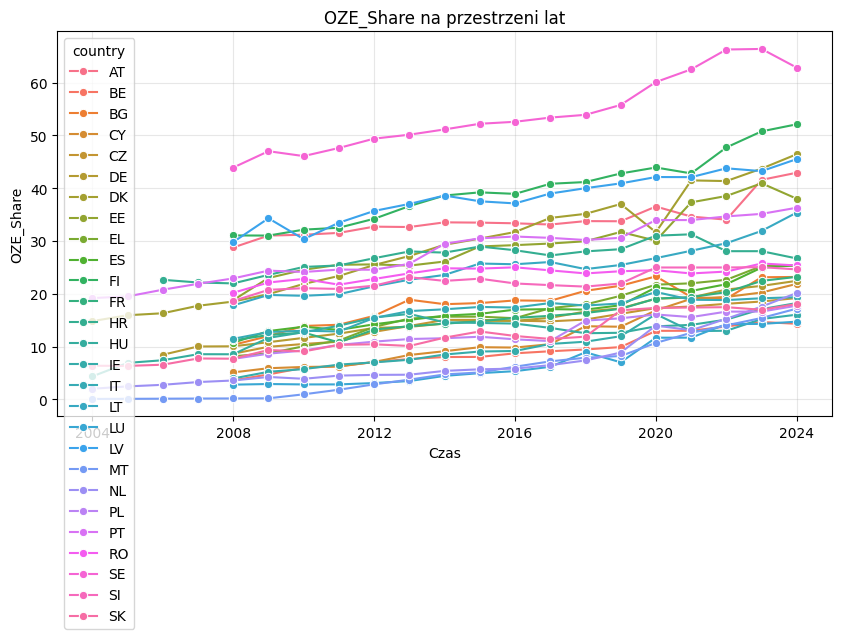

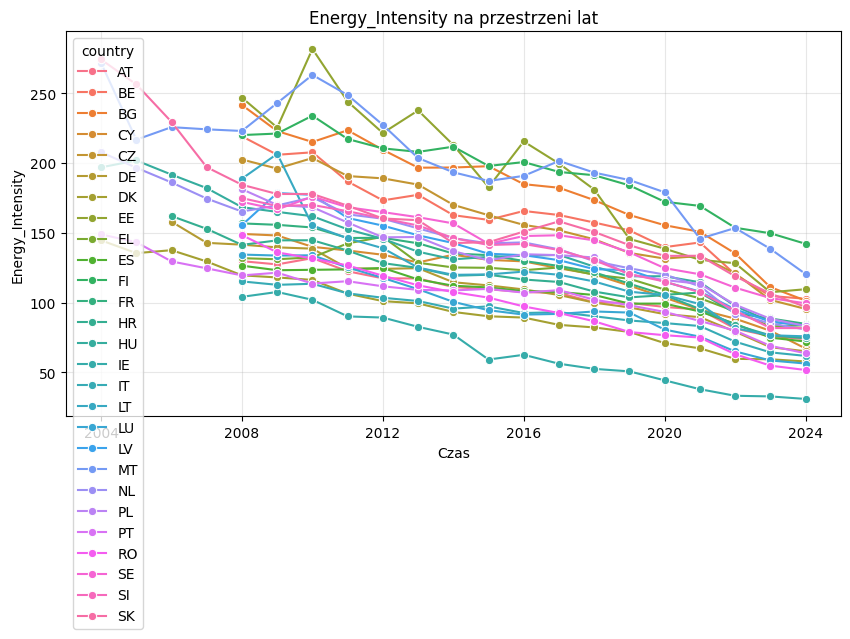

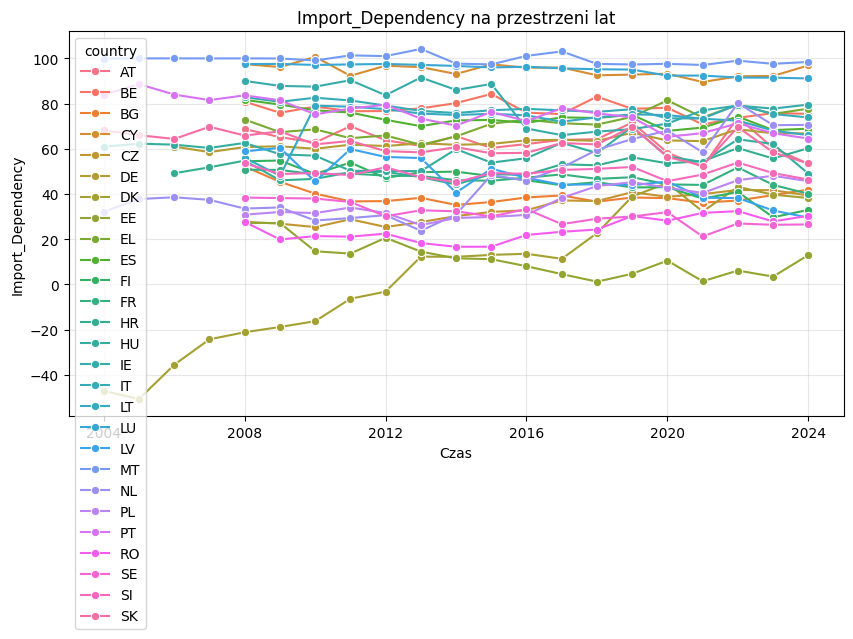

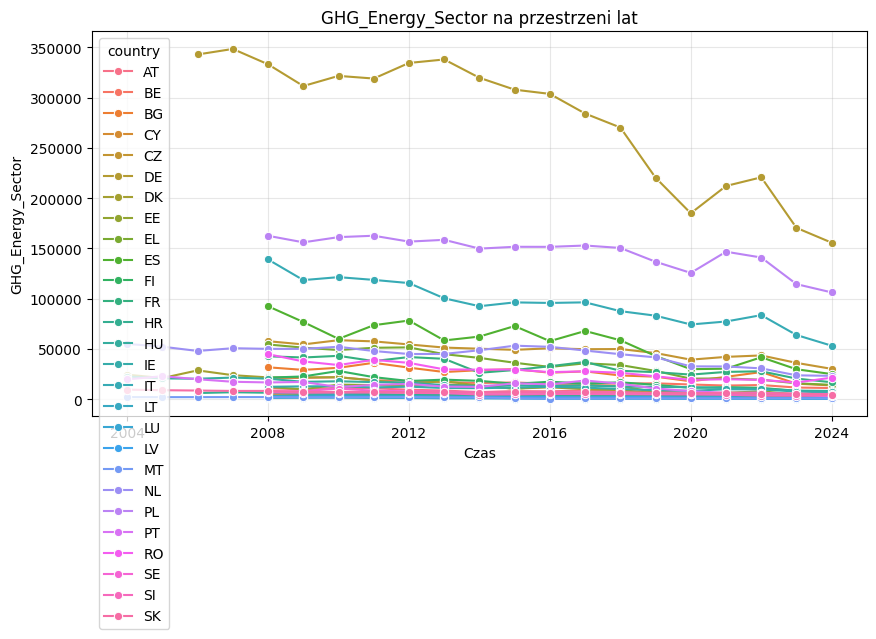

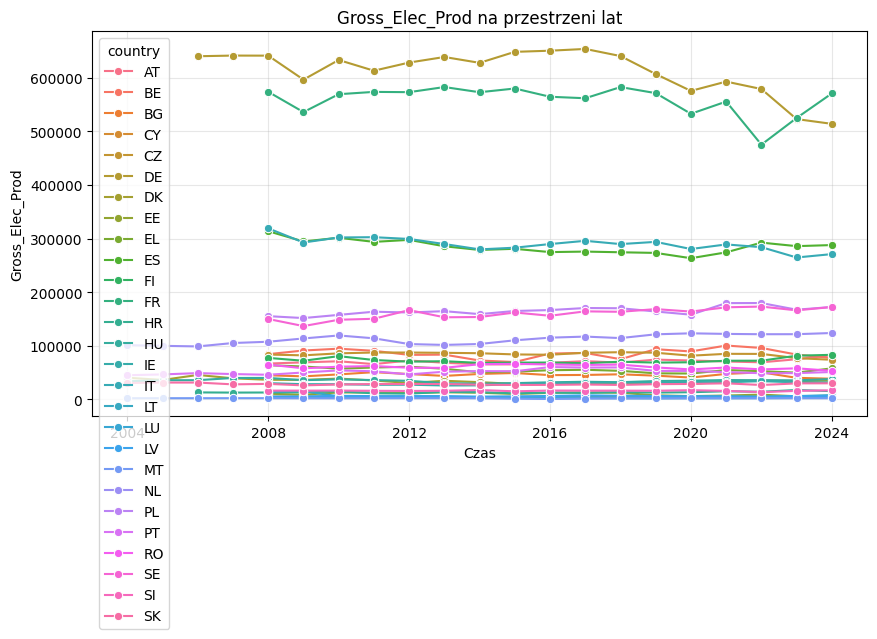

In [54]:
for _, v in indicators.items():
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=data.index.get_level_values(0), y=data[v], marker='o', hue=data.index.get_level_values(1))
    plt.title(f'{v} na przestrzeni lat')
    plt.xlabel('Czas')
    plt.ylabel(v)
    plt.grid(alpha=0.3)
    plt.show()


In [63]:
# Zamiana destymulant na stymulanty
for col, v_type in variable_types.items():
    if col in data.columns and v_type == 'D':
        data[col] = -1 * data[col]

In [64]:
# 3. Standaryzacja (z-score) i podgląd
scaler = StandardScaler()
df_std = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
print('\nPrzykładowe wiersze po standaryzacji:')
print(df_std.head())


Przykładowe wiersze po standaryzacji:
            OZE_Share  Energy_Intensity  Import_Dependency  GHG_Energy_Sector  \
Rok                                                                             
2008-01-01  -1.668110         -1.812731           0.796087          -1.127485   
2009-01-01  -1.323461         -1.363231           0.623267          -0.584312   
2010-01-01  -1.112842         -1.298732           0.692454          -1.016925   
2011-01-01  -0.745217         -0.860380           0.333181          -1.134425   
2012-01-01  -0.530072         -0.439546           0.683805          -0.645312   

            Gross_Elec_Prod  
Rok                          
2008-01-01        -1.241142  
2009-01-01        -1.715452  
2010-01-01        -0.929516  
2011-01-01        -0.149795  
2012-01-01        -0.336273  


In [65]:
# 4. Konstrukcja indeksów agregatowych
# --- a) Equal Weighting (srednia standaryzowanych)
data["equal_weighting"] = df_std.mean(axis=1)


In [66]:
# --- b) PCA (główna składowa) standaryzowanych
pca = PCA(n_components=1)
pca_result = pca.fit_transform(df_std)

data['PCA'] = pca_result

In [67]:
# --- c) Entropy Weighting Method (normalizacja MinMax)
minmax = MinMaxScaler()
df_norm = pd.DataFrame(minmax.fit_transform(data[indicators.values()]), columns=indicators.values(), index=data.index)

P = df_norm / (df_norm.sum(axis=0) + 1e-8)
P = np.where(P == 0, 1e-10, P)
E = (-P * np.log(P)).mean(axis=0) / np.log(len(data))
d = 1 - E
ewm_weights = d / d.sum()
data["entropy_weighting"] = (df_norm * ewm_weights).sum(axis=1)

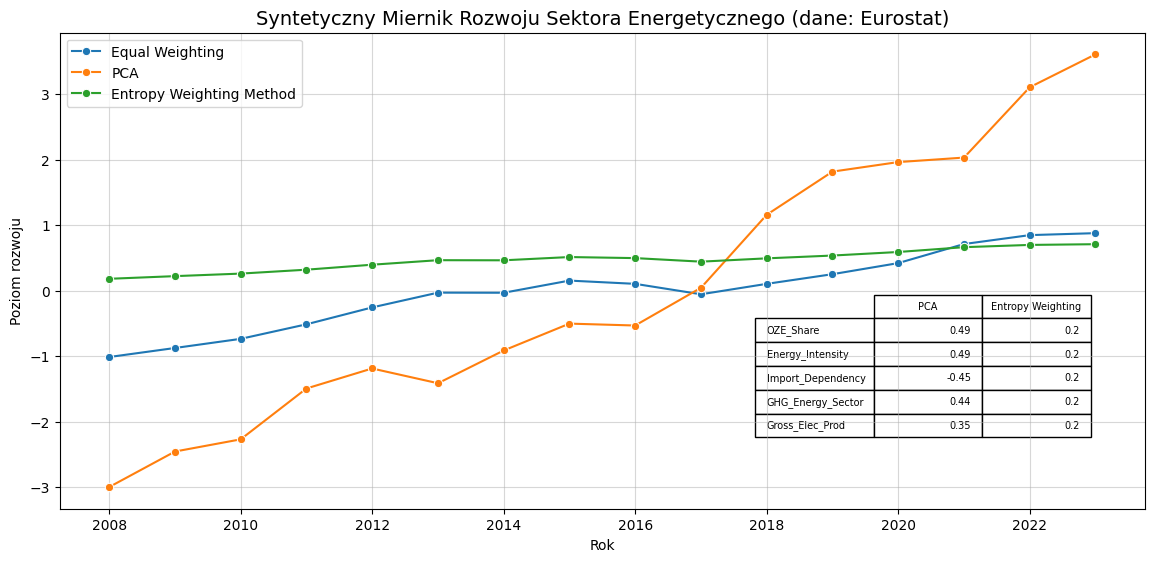

In [69]:
plt.figure(figsize=(14, 7))

# Wykres główny
sns.lineplot(x=data.index, y=data['equal_weighting'], label='Equal Weighting', marker='o')
sns.lineplot(x=data.index, y=data['PCA'], label='PCA', marker='o')
sns.lineplot(x=data.index, y=data['entropy_weighting'], label='Entropy Weighting Method', marker='o')

plt.title(f'Syntetyczny Miernik Rozwoju Sektora Energetycznego (dane: Eurostat)', fontsize=14)
plt.ylabel('Poziom rozwoju')
plt.xlabel('Rok')
plt.legend()


# Tabela z wagami (ładunki czynnikowe)
indicator_cols = list(indicators.values())
loadings = pd.DataFrame(
    {
        'PCA': pca.components_[0],
        'Entropy Weighting': ewm_weights
    }
)

plt.table(cellText=np.round(loadings.values, 2),
          rowLabels=list(indicators.values()),
          colLabels=loadings.columns,
          loc='bottom', bbox=[0.75, 0.15, 0.2, 0.3])
plt.subplots_adjust(bottom=0.2)
plt.grid(True, which='major', alpha=0.5)

plt.show()

In [70]:
# 5. Analiza mozliwosci Random Forest
trend = data['equal_weighting'].rolling(window=8, min_periods=1).mean().corr(pd.Series(np.arange(len(data['equal_weighting'])), index=data['equal_weighting'].index))
if len(data) < 100 and abs(trend) > 0.4:
    print("\nUWAGA: Liczba obserwacji < 100 i obecny silny trend. NIE zaleca się metody Random Forest do prognozowania tych szeregów.")
else:
    print("\nRandom Forest może byc potencjalnie wykorzystany (liczba obserwacji i/lub trend nie zaburzają uczenia).")


UWAGA: Liczba obserwacji < 100 i obecny silny trend. NIE zaleca się metody Random Forest do prognozowania tych szeregów.


In [71]:
# 6. Podział na okres treningowy+test+prognoza
steps_ahead = 2
train = df_std.iloc[:-steps_ahead]
test = df_std.iloc[-steps_ahead:]

print(f'\nLiczba obserwacji w zbiorze treningowym: {len(train)}')
print(f'Liczba obserwacji w zbiorze testowym: {len(test)}')


Liczba obserwacji w zbiorze treningowym: 14
Liczba obserwacji w zbiorze testowym: 2


In [72]:
# 7. Bezpośrednia prognoza indeksu agregatowego
def eval_metrics(actual, pred):
    me = np.mean(pred - actual)
    mpe = 100*np.mean((pred - actual) / actual)
    mae = np.mean(np.abs(pred - actual))
    mape = 100*np.mean(np.abs((pred - actual) / actual))
    rmse = np.sqrt(np.mean((pred - actual) ** 2))
    rmspe = 100 * (rmse / np.mean(actual)) if np.mean(actual) != 0 else np.nan
    t = np.sqrt(np.mean(((pred[1:] - actual[1:])**2)) / np.mean((actual[1:]**2)))
    return {'ME': me, 'MPE': mpe, 'MAE': mae, 'MAPE': mape, 'RMSE': rmse, 'RMSPE': rmspe, 'Theil': t}


def best_time_model(series, horizon, models_config):
    min_rmspe = float('inf')
    best_model = None
    best_pred = None
    best_model_name = "Fallback (Last Value)" # Domyślna nazwa w razie błędu

    print(f"\n--- Rozpoczynam trenowanie {len(models_config)} modeli ---")

    # Iteracja po słowniku modeli
    for name, (func, params) in models_config.items():
        pred, model, metric = func(series, horizon, **params)
        
        # Sprawdzenie czy model zwrócił wynik (czy nie było wyjątku)
        if pred is not None and metric is not None:
            print(f"Model: {name:20} | RMSPE: {metric:.4f}%")
            
            # Jeśli błąd jest mniejszy niż dotychczasowy najlepszy -> aktualizujemy
            if metric < min_rmspe:
                min_rmspe = metric
                best_model = model
                best_pred = pred
                best_model_name = name
            else:
                print(f"Model: {name:20} | brak konwergencji")
        else:
            print(f"Model: {name:20} | BŁĄD")

    # Obsługa przypadku, gdy wszystkie modele zawiodły (Fallback)
    if best_pred is None or np.isnan(best_pred).any():
        print(f"\nWARNING: Wszystkie modele zawiodły. Używam fallback.")
        fallback_value = series.dropna().iloc[-1] if not series.dropna().empty else 0
        best_pred = np.full(horizon, fallback_value)
    else:
        print(f"\n>>> ZWYCIĘZCA: {best_model_name} (RMSPE: {min_rmspe:.4f}%)")

    return best_pred, best_model_name, best_model


In [73]:
def OLS(series, horizon):
    s = series.dropna()
    try:
        X = np.arange(len(s))
        X_mat = X[:,None]
        model = sm.OLS(s.values, sm.add_constant(X_mat)).fit()
        exog_pred = np.arange(len(s), len(s)+horizon)[:,None]
        ols_pred = model.predict(sm.add_constant(exog_pred))
        rmspe_ols = 100*np.sqrt(np.mean(((model.fittedvalues - s.values)/s.values)**2))
        return ols_pred, model, rmspe_ols
    except Exception as e:
        print(f"OLS model error: {e}")
        return None, None, None
    
def Holt_Winters(series, horizon):
    s = series.dropna()
    try:
        hw = ExponentialSmoothing(s, trend='add').fit()
        hw_pred = hw.forecast(horizon)
        rmspe_hw = 100*np.sqrt(np.mean(((hw.fittedvalues - s.values) / s.values) ** 2))
        return hw_pred, hw, rmspe_hw
    except Exception as e:
        print(f"Holt-Winters model error: {e}")
        return None, None, None
    
def SARIMA(series, horizon, AR=1, I=1, MA=1):
    s = series.dropna()
    try:
        sarima = SARIMAX(s, order=(AR, I, MA)).fit(disp=False)
        sarima_pred = sarima.forecast(horizon)
        rmspe_sarima = 100*np.sqrt(np.mean(((sarima.fittedvalues - s.values) / s.values) ** 2))
        return sarima_pred, sarima, rmspe_sarima
    except Exception as e:
        print(f"SARIMA model error: {e}")
        return None, None, None

In [74]:
# MODELS CONFIG
models_to_test = {
    'OLS_Trend': (OLS, {}),
    'Holt_Winters': (Holt_Winters, {}),
    'SARIMA_0_1_0': (SARIMA, {'AR': 0, 'I': 1, 'MA': 0}),
    'SARIMA_Default': (SARIMA, {'AR': 1, 'I': 1, 'MA': 1}),
    'SARIMA_1_1_0': (SARIMA, {'AR': 1, 'I': 1, 'MA': 0}),
    'SARIMA_2_1_2': (SARIMA, {'AR': 2, 'I': 1, 'MA': 2})
}


>>> Prognozy BEZPOŚREDNIE indeksów na 2 lata do przodu <<<

[EW] Model: OLS trend (Forced)
Miary trafności: {'ME': np.float64(-0.08387355208420083), 'MPE': np.float64(-9.778860718335466), 'MAE': np.float64(0.08387355208420083), 'MAPE': np.float64(9.778860718335466), 'RMSE': np.float64(0.09359176472919617), 'RMSPE': np.float64(10.815545144832178), 'Theil': np.float64(0.04809797286352767)}


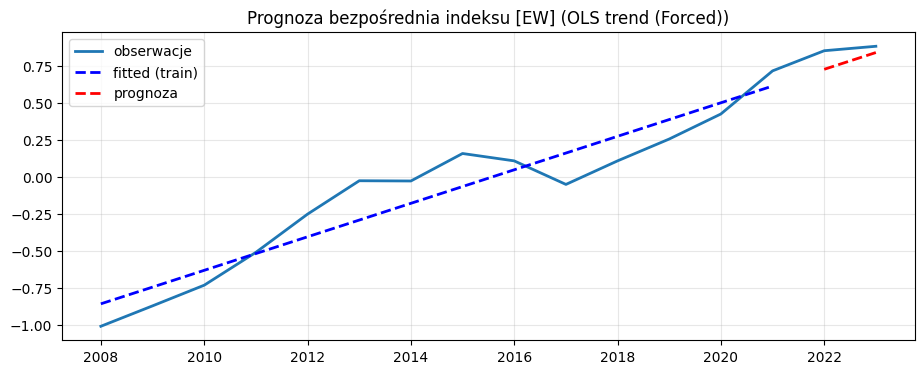

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.891
Method:                 Least Squares   F-statistic:                     107.4
Date:                Fri, 28 Nov 2025   Prob (F-statistic):           2.43e-07
Time:                        00:28:47   Log-Likelihood:                 6.4686
No. Observations:                  14   AIC:                            -8.937
Df Residuals:                      12   BIC:                            -7.659
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8590      0.083    -10.288      0.0

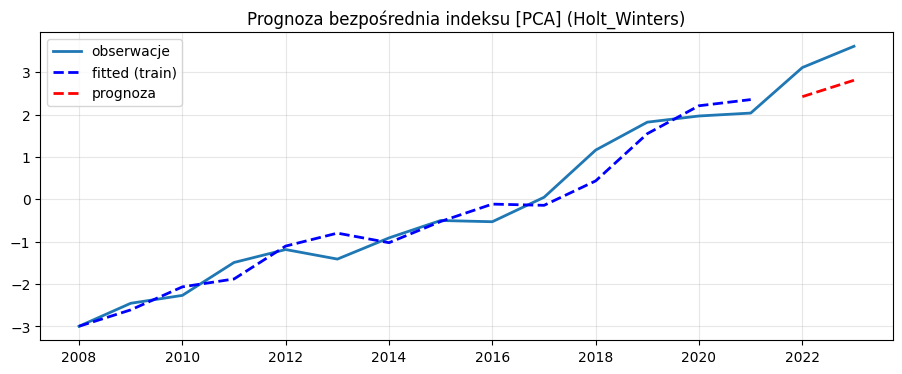

                       ExponentialSmoothing Model Results                       
Dep. Variable:                      PCA   No. Observations:                   14
Model:             ExponentialSmoothing   SSE                              1.581
Optimized:                         True   AIC                            -22.533
Trend:                         Additive   BIC                            -19.977
Seasonal:                          None   AICC                           -10.533
Seasonal Periods:                  None   Date:                 Fri, 28 Nov 2025
Box-Cox:                          False   Time:                         00:28:48
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.0000

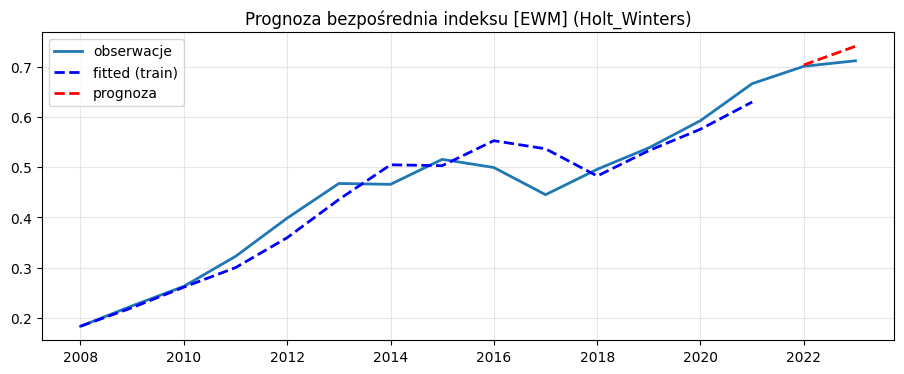

                       ExponentialSmoothing Model Results                       
Dep. Variable:        entropy_weighting   No. Observations:                   14
Model:             ExponentialSmoothing   SSE                              0.018
Optimized:                         True   AIC                            -85.412
Trend:                         Additive   BIC                            -82.856
Seasonal:                          None   AICC                           -73.412
Seasonal Periods:                  None   Date:                 Fri, 28 Nov 2025
Box-Cox:                          False   Time:                         00:28:48
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.0000

,ME,MPE,MAE,MAPE,RMSE,RMSPE,Theil
EW (Direct - OLS),-0.0839,-9.7789,0.0839,9.7789,0.0936,10.8155,0.0481
PCA (Direct - Holt_Winters),-0.7444,-22.1571,0.7444,22.1571,0.7466,22.2271,0.2221
EWM (Direct - Holt_Winters),0.0158,2.2192,0.0158,2.2192,0.0205,2.8993,0.0405


In [75]:
print('\n>>> Prognozy BEZPOŚREDNIE indeksów na 2 lata do przodu <<<')
method_labels = {'EW': data['equal_weighting'], 'PCA': data['PCA'], 'EWM': data['entropy_weighting']}
direct_metrics = {}
for met, idx in method_labels.items():
    idx_train = idx.iloc[:-steps_ahead]
    idx_test = idx.iloc[-steps_ahead:]

    # --- Explicitly use OLS with seasonal dummies for EW index
    if met == 'EW':
        model_name = 'OLS trend (Forced)'
        try:
            X_train = np.arange(len(idx_train))
            dummies_train = None
            X_train_mat = np.column_stack([X_train, dummies_train.values]) if dummies_train is not None else X_train[:,None]
            model = sm.OLS(idx_train.values, sm.add_constant(X_train_mat)).fit()
            fitted_train = pd.Series(model.fittedvalues, index=idx_train.index)


            exog_pred = np.column_stack([np.arange(len(idx_train), len(idx_train)+steps_ahead),
                                        np.eye(dummies_train.shape[1])[
                                            [i%dummies_train.shape[1] for i in range(len(idx_train), len(idx_train)+steps_ahead)]
                                        ]]) if dummies_train is not None else np.arange(len(idx_train), len(idx_train)+steps_ahead)[:,None]
            fc_array = model.predict(sm.add_constant(exog_pred))
            fc = pd.Series(fc_array, index=idx_test.index)
            metrics = eval_metrics(idx_test, fc)
            direct_metrics[f'{met} (Direct - OLS)'] = metrics
            print(f'\n[{met}] Model: {model_name}\nMiary trafności:', metrics)


        except Exception as e:
            print(f"\n[{met}] OLS model fitting failed: {e}")
            fc = pd.Series(np.nan, index=idx_test.index)
            fitted_train = pd.Series(np.nan, index=idx_train.index)
            direct_metrics[f'{met} (Direct - OLS)'] = {'ME': np.nan, 'MPE': np.nan, 'MAE': np.nan, 'MAPE': np.nan, 'RMSE': np.nan, 'RMSPE': np.nan, 'Theil': np.nan}


    else:
        # wybór najlepszego modelu
        fc_array, model_name, model = best_time_model(idx_train, steps_ahead, models_to_test)
        fc = pd.Series(fc_array, index=idx_test.index) # Convert to Series and assign index
        print("fc: ", fc)
        metrics = eval_metrics(idx_test, fc)
        direct_metrics[f'{met} (Direct - {model_name})'] = metrics
        print(f'\n[{met}] Najlepszy model: {model_name}\nMiary trafności:', metrics)

        try:
            fitted_train = pd.Series(model.fittedvalues, index=idx_train.index)
        except Exception as e:
            print(f"Could not get fitted values for {met} ({model_name}): {e}")
            fitted_train = None

    plt.figure(figsize=(11,4))
    plt.title(f'Prognoza bezpośrednia indeksu [{met}] ({model_name})')
    plt.plot(idx, label='obserwacje', lw=2)
    if fitted_train is not None:
        plt.plot(idx_train.index, fitted_train, 'b--', label='fitted (train)', lw=2)
    plt.plot(idx_test.index, fc, 'r--', label='prognoza', lw=2)
    plt.legend()
    plt.grid(alpha=0.3) 
    plt.show()
    print(model.summary())

print('\n===============================')
print('PODSUMOWANIE MIAR TRAFNOŚCI PROGNOZ (OKRES TESTOWY - Prognoza bezpośrednia):')
direct_metrics_df = pd.DataFrame(direct_metrics).T.map(lambda x: round(x, 4) if isinstance(x, (int, float)) else x)
display(direct_metrics_df)


In [ ]:
# TODO: Prognozowanie składników bazowych osobno, a następnie ich agregacja (te same metody, wybór najlepszej dla każdego składnika na podstawie RMSPE).
# TODO: Porównanie skuteczności obu podejść.

# Wizualizacja i raport (8-10 stron w formacie .pdf przesłany na eNauczaniu) 
